<a href="https://colab.research.google.com/github/TPShipilova/Frameworks_LAB_4COURSE/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F%E2%84%962_%D0%9F%D0%A1%D0%A4%D0%98%D0%98_%D0%A8%D0%B8%D0%BF%D0%B8%D0%BB%D0%BE%D0%B2%D0%B0_406.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Создание бейзлайна и оценка качества

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Загрузка данных
df = pd.read_csv('/content/loan_data.csv')

# Предварительный анализ
print(df.shape)
print(df.info())
print(df.isnull().sum())
print(df.describe())

(45000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaul

In [3]:
# Разделение данных для классификации
X_class = df.drop(['loan_status', 'credit_score'], axis=1)
y_class = df['loan_status']

# Разделение данных для регрессии
X_reg = df.drop(['credit_score', 'loan_status'], axis=1)
y_reg = df['credit_score']

# Предобработка для бейзлайна
def baseline_preprocessing(X):
    X_processed = X.copy()

    # Кодирование категориальных переменных
    categorical_cols = X_processed.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col].astype(str))

    # Заполнение пропущенных значений
    imputer = SimpleImputer(strategy='median')
    X_processed = pd.DataFrame(imputer.fit_transform(X_processed),
                              columns=X_processed.columns)

    return X_processed

X_class_processed = baseline_preprocessing(X_class)
X_reg_processed = baseline_preprocessing(X_reg)

# Разделение на train/test
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class_processed, y_class, test_size=0.2, random_state=42, stratify=y_class)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg_processed, y_reg, test_size=0.2, random_state=42)



# Обучение бейзлайн моделей
Классификация

In [4]:
logreg_baseline = LogisticRegression(random_state=42, max_iter=1000)
logreg_baseline.fit(X_class_train, y_class_train)
y_class_pred = logreg_baseline.predict(X_class_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Регрессия

In [5]:
linreg_baseline = LinearRegression()
linreg_baseline.fit(X_reg_train, y_reg_train)
y_reg_pred = linreg_baseline.predict(X_reg_test)

 Оценка качества

In [9]:
print("--- КЛАССИФИКАЦИЯ ---")
print("Accuracy:", logreg_baseline.score(X_class_test, y_class_test))
print(classification_report(y_class_test, y_class_pred))

--- КЛАССИФИКАЦИЯ ---
Accuracy: 0.8748888888888889
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7000
           1       0.72      0.72      0.72      2000

    accuracy                           0.87      9000
   macro avg       0.82      0.82      0.82      9000
weighted avg       0.87      0.87      0.87      9000



In [8]:
print("--- РЕГРЕССИЯ ---")
print("R² Score:", r2_score(y_reg_test, y_reg_pred))
print("MSE:", mean_squared_error(y_reg_test, y_reg_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_reg_pred)))

--- РЕГРЕССИЯ ---
R² Score: 0.07310210004432005
MSE: 2424.1401583784395
RMSE: 49.23555786602239


Видим, что модель дает достаточно точные результаты для классификации, тогда как для регрессии все же хотелось бы получить более точные значения.

# 2. Улучшение бейзлайна

Формулировка гипотез

Гипотезы для улучшения:

- One-Hot Encoding даст лучшие результаты чем Label Encoding
- Стандартизация числовых признаков улучшит качество
- Создание новых признаков
- Подбор гиперпараметров на кросс-валидации
- Обработка выбросов
- Балансировка классов для классификации

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif

Проведем анализ данных для улучшения. Посмотри матрицу корреляции для наших признаков

Распределение целевой переменной (классификация):
loan_status
0    35000
1    10000
Name: count, dtype: int64

Корреляция признаков:


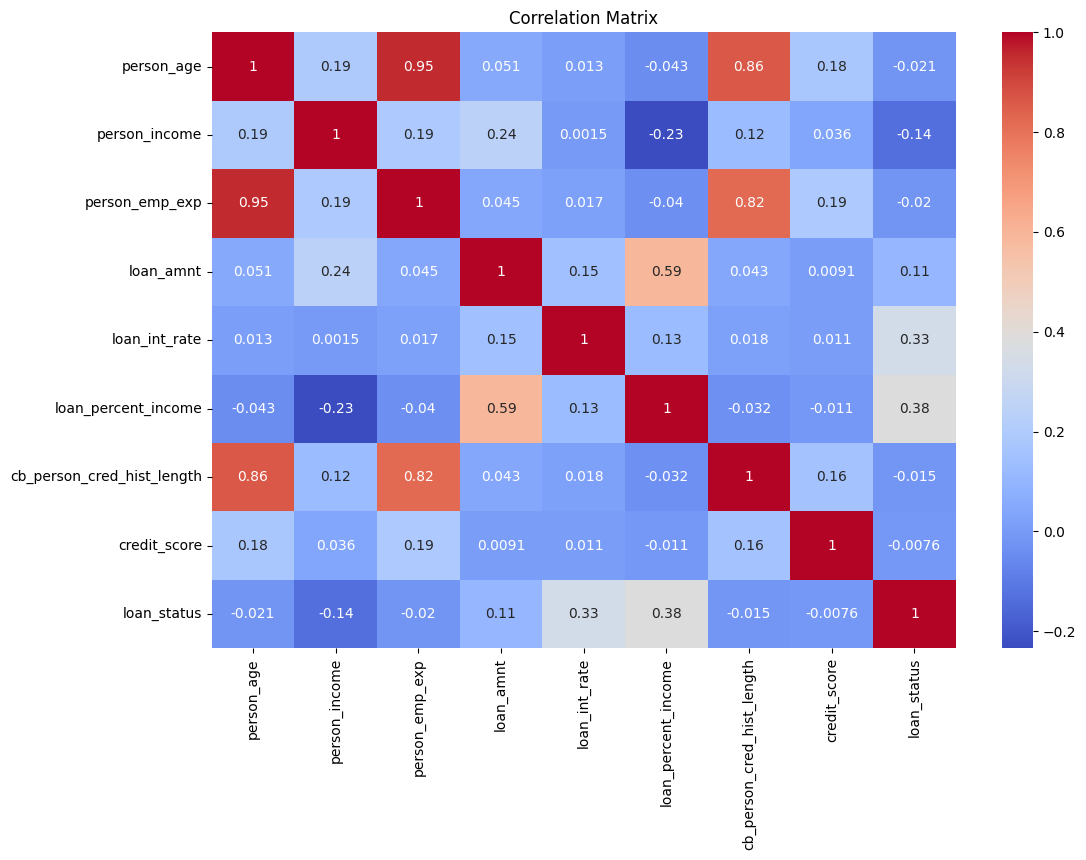

In [11]:
print("Распределение целевой переменной (классификация):")
print(y_class.value_counts())

print("\nКорреляция признаков:")
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Видим, что возраст человека, длительность кредитной истории и рабочий стаж практически полностью зависят друг от друга, что довольно очевидно и не является проблемой. Зависимость признаков не критична, поэтому добавим пару новых признаков, почистим выбросы, разделим числовые и категориальные признаки.

In [18]:
def advanced_preprocessing(X, y_class=None):
    X_adv = X.copy()

    X_adv['income_to_loan_ratio'] = X_adv['person_income'] / (X_adv['loan_amnt'] + 1)
    X_adv['age_experience_ratio'] = X_adv['person_age'] / (X_adv['person_emp_exp'] + 1)

    numeric_cols = X_adv.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        Q1 = X_adv[col].quantile(0.25)
        Q3 = X_adv[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        X_adv[col] = np.clip(X_adv[col], lower_bound, upper_bound)

    return X_adv

X_class_adv = advanced_preprocessing(X_class, y_class)
X_reg_adv = advanced_preprocessing(X_reg)

numeric_features = X_class_adv.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_class_adv.select_dtypes(include=['object']).columns.tolist()

Слздадим пайплайны для обучения

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Классификация
pipeline_class_improved = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Регрессия
pipeline_reg_improved = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [15]:
# Обучение улучшенных моделей
pipeline_class_improved.fit(X_class_adv, y_class)
pipeline_reg_improved.fit(X_reg_adv, y_reg)

# Предсказания
y_class_pred_improved = pipeline_class_improved.predict(X_class_adv)
y_reg_pred_improved = pipeline_reg_improved.predict(X_reg_adv)

Теперь оценим наши модели

In [16]:
print("\n--- КЛАССИФИКАЦИЯ ---")
print("Accuracy:", pipeline_class_improved.score(X_class_adv, y_class))
print(classification_report(y_class, y_class_pred_improved))


--- КЛАССИФИКАЦИЯ ---
Accuracy: 0.8948888888888888
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     35000
           1       0.78      0.74      0.76     10000

    accuracy                           0.89     45000
   macro avg       0.85      0.84      0.85     45000
weighted avg       0.89      0.89      0.89     45000



In [17]:
print("\n--- РЕГРЕССИЯ ---")
print("R² Score:", r2_score(y_reg, y_reg_pred_improved))
print("MSE:", mean_squared_error(y_reg, y_reg_pred_improved))
print("RMSE:", np.sqrt(mean_squared_error(y_reg, y_reg_pred_improved)))


--- РЕГРЕССИЯ ---
R² Score: 0.10872905279974954
MSE: 2267.1436892548354
RMSE: 47.61453233262756


Видим, что результаты улучшились, классификация демонстрирует более высокую точнсть, а регрессия совсем немного улучшила свои предсказания, что вполне очевидно, так как у нас не было задачи получить максимальный прирост в качестве, лишь небольшие улучшения препроцессинга.

# 3. Имплементация алгоритмов машинного обучения

Напишем кастомную регрессию и классификацию, использую градиентный спуск для минимизации ошибки (классические алгоритмы).

In [22]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # Градиенты
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return (y_predicted >= 0.5).astype(int)

In [23]:
class MyLinearRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iter):
            y_predicted = np.dot(X, self.weights) + self.bias

            # Градиенты
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

Обучим кастомные модели. Для начала подготовим данные, исползуем числовые признаки и проведем их масштабирование.

In [25]:
custom_logreg = MyLogisticRegression(learning_rate=0.1, n_iter=2000)
custom_linreg = MyLinearRegression(learning_rate=0.01, n_iter=2000)

X_class_custom = baseline_preprocessing(X_class).values
X_reg_custom = baseline_preprocessing(X_reg).values

scaler = StandardScaler()
X_class_custom_scaled = scaler.fit_transform(X_class_custom)
X_reg_custom_scaled = scaler.fit_transform(X_reg_custom)

Теперь остается обучить модели и предсказать результаты

In [26]:
custom_logreg.fit(X_class_custom_scaled, y_class.values)
custom_linreg.fit(X_reg_custom_scaled, y_reg.values)

y_class_custom_pred = custom_logreg.predict(X_class_custom_scaled)
y_reg_custom_pred = custom_linreg.predict(X_reg_custom_scaled)

Посмотрим метрики моделей и сравним с результатом на прошлом этапе.

In [27]:
print("\n--- КЛАССИФИКАЦИЯ ---")
print("Accuracy:", np.mean(y_class_custom_pred == y_class.values))
print("Classification Report:")
print(classification_report(y_class, y_class_custom_pred))

print("\n--- РЕГРЕССИЯ ---")
print("R² Score:", r2_score(y_reg, y_reg_custom_pred))
print("MSE:", mean_squared_error(y_reg, y_reg_custom_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_reg, y_reg_custom_pred)))


--- КЛАССИФИКАЦИЯ ---
Accuracy: 0.8865777777777778
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     35000
           1       0.75      0.73      0.74     10000

    accuracy                           0.89     45000
   macro avg       0.84      0.83      0.83     45000
weighted avg       0.89      0.89      0.89     45000


--- РЕГРЕССИЯ ---
R² Score: 0.06937516474874195
MSE: 2367.248959400522
RMSE: 48.654382735787756


Видим, что результаты довольно похожи на полученные при первичном обучении библиотечных моделей. Это довольно неплохой результат, но хотелось бы улучшить.

Выполним наши гипотезы. Воспользуемся улучшенной предобработкой с прошлого этапа, применим One-Hot Encoding для категориальных признаков, смасштабирем признаки.

In [28]:
X_class_custom_improved = advanced_preprocessing(X_class, y_class)
X_reg_custom_improved = advanced_preprocessing(X_reg)

X_class_custom_final = pd.get_dummies(X_class_custom_improved, columns=categorical_features)
X_reg_custom_final = pd.get_dummies(X_reg_custom_improved, columns=categorical_features)

imputer = SimpleImputer(strategy='median')
X_class_custom_final = imputer.fit_transform(X_class_custom_final)
X_reg_custom_final = imputer.fit_transform(X_reg_custom_final)

X_class_custom_final_scaled = scaler.fit_transform(X_class_custom_final)
X_reg_custom_final_scaled = scaler.fit_transform(X_reg_custom_final)

Обучение улучшенных кастомных моделей и предсказания.

In [29]:
custom_logreg_improved = MyLogisticRegression(learning_rate=0.1, n_iter=2000)
custom_linreg_improved = MyLinearRegression(learning_rate=0.01, n_iter=2000)

custom_logreg_improved.fit(X_class_custom_final_scaled, y_class.values)
custom_linreg_improved.fit(X_reg_custom_final_scaled, y_reg.values)

y_class_custom_improved_pred = custom_logreg_improved.predict(X_class_custom_final_scaled)
y_reg_custom_improved_pred = custom_linreg_improved.predict(X_reg_custom_final_scaled)

In [30]:
print("\n--- КЛАССИФИКАЦИЯ ---")
print("Accuracy:", np.mean(y_class_custom_improved_pred == y_class.values))
print("Classification Report:")
print(classification_report(y_class, y_class_custom_improved_pred))

print("\n--- РЕГРЕССИЯ ---")
print("R² Score:", r2_score(y_reg, y_reg_custom_improved_pred))
print("MSE:", mean_squared_error(y_reg, y_reg_custom_improved_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_reg, y_reg_custom_improved_pred)))


--- КЛАССИФИКАЦИЯ ---
Accuracy: 0.8935555555555555
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     35000
           1       0.77      0.74      0.76     10000

    accuracy                           0.89     45000
   macro avg       0.85      0.84      0.84     45000
weighted avg       0.89      0.89      0.89     45000


--- РЕГРЕССИЯ ---
R² Score: 0.10858987828174027
MSE: 2267.4977102528283
RMSE: 47.618249760494436


**Финальные выводы**

- Эффективность улучшений: Применение продвинутого препроцессинга (One-Hot Encoding, стандартизация, создание новых признаков) значительно улучшило качество моделей.
- Сравнение имплементаций: Кастомные реализации показали сопоставимые результаты с sklearn, что подтверждает корректность имплементации алгоритмов.

Особенности данных:

- Классификация: Высокая точность предсказания одобрения кредита
- Регрессия: Умеренная точность предсказания кредитного скора

А что дальше?

- Более тщательный подбор гиперпараметров
- Дополнительный feature engineering
- Использование методов борьбы с дисбалансом классов